In [2]:
import matplotlib
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA

sns.set_context('poster')
sns.set_style('white')

pd.options.mode.chained_assignment = None  # default='warn'

import hdbscan
from collections import Counter
from collections import defaultdict
from numpy import random

(Вспомогательная процедура, которая рисует легенду с обозначением цветов.)

In [3]:
def draw_legend(class_colours, classes, right=False):
    recs = []
    for i in range(0, len(classes)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    if right:
        plt.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(recs, classes)

SNP, встречающиеся в комбинации стрейнов

In [15]:
 def plot_shared_snps(f_pca, f_0_pca, mask, names, draw_all=False):
    combs = []
    combs_nums = []
    combinations = []

    for m in mask:
        if not draw_all:
            if not (np.sum(m) > 1):
                combinations.append(-1)
                continue
        cur = ""
        for i in range(len(m)):
            if m[i] == 1:
                if cur != "":
                    cur += " + "
                cur += names[i] 
        if cur == "":
            cur = "none"                   
        if cur not in combs:
            combs.append(cur)
            combs_nums.append(0)
        combs_nums[combs.index(cur)] += 1
        combinations.append(combs.index(cur))

    df = pd.DataFrame({'pc1':f_pca[:, 0], 'pc2':f_pca[:, 1], 'combination':combinations})
    df_valid = df.loc[df['combination'] != -1]

    # reoder combinations by sizes of groups
    order = sorted(zip(combs_nums, combs, range(12)), reverse=True)
    new_comb_order = [0] * (2 ** len(mask[0]))
    new_comb_names = [] 
    for i in range(len(order)):
        old_order = order[i][2]
        new_comb_order[old_order] = i
        new_comb_names.append('{:5d}'.format(order[i][0]) + '  ' + order[i][1])
        #new_comb_names.append(order[i][1])
    for i in df_valid.index:
        df_valid.loc[i, "combination"] = new_comb_order[df_valid.loc[i, "combination"]]

    # Kelly’s 20 (except the first 2) Colours of Maximum Contrast
    colors = ['orange', 'purple', '#96cde6', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    color_palette = sns.color_palette(colors)
    cluster_colors = [color_palette[x] for x in df_valid["combination"]]

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.scatter(f_0_pca[:, 0], f_0_pca[:, 1], s=40, linewidth=0, c="grey", alpha=0.5);
    plt.scatter(df_valid["pc1"], df_valid["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.9);
    #plt.title("[Sharon et al, 2013]")
    draw_legend(color_palette, new_comb_names, right=True)

In [5]:
def clusterization(f, pca=True, num_of_comp=2):
    
    if pca:
        f_pca = PCA(n_components = num_of_comp).fit(f).transform(f)
        cur_f = f_pca
    else:
        cur_f = f
        f_pca = PCA(n_components = 2).fit(f).transform(f)
    
    #N = (nt) (len(f) * 0.005)
    #print(N)
    N = 100

    clusterer = hdbscan.HDBSCAN(min_cluster_size=N, min_samples=1).fit(cur_f)
    
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    if pca:
        plt.title("Clustering %s primary components" % num_of_comp)
    else:
        plt.title("Clustering initial frequencies")        
    
    color_palette = sns.color_palette("Set2", 20)
    cluster_colors = [color_palette[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clusterer.probabilities_)]
    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=40, linewidth=0, c=cluster_member_colors, alpha=0.3);
    
    sizes_of_classes = Counter(clusterer.labels_)
    print(sizes_of_classes.get(-1, 0), "outliers\n")
    labels = [str(x) + ' - ' + str(sizes_of_classes[x]) for x in range(max(clusterer.labels_)+1)]
    draw_legend(color_palette, labels, right=True)  
        
    print("Medians in clusters:")
    for i in range(max(clusterer.labels_)+1):
        f_with_labels = f.copy()
        f_with_labels = np.hstack([f_with_labels, clusterer.labels_.reshape(len(f_with_labels),1)])
        col = f_with_labels[:, -1]
        idx = (col == i)
        print(i, np.round(np.median(f_with_labels[idx,:-1], axis=0), 2))

# Infant Gut, выровненный на Strain 1
(Преобразование не делаем, так как референс есть в данных)

##### Частоты стрейнов в Infant Gut:

strain1 0.73 0.74 0.04 0.13 0.17 0.04 0.32 0.75 0.30 0.20 0.0

strain3 0.24 0.20 0.95 0.80 0.80 0.93 0.52 0.19 0.64 0.65 1.0

strain4 0.03 0.06 0.02 0.07 0.03 0.02 0.16 0.06 0.06 0.15 0.0

In [13]:
def filter_by_coverage(cur_r, bad_percent, bad_samples):
    def filter_row(row):
        num_of_samples = len(row)
        valid = np.sum(np.array(([(min_coverage < row) & (row < max_coverage)])))
        return num_of_samples - valid <= bad_samples

    min_coverage = np.percentile(cur_r, bad_percent, axis=0)
    max_coverage = np.percentile(cur_r, 100-bad_percent, axis=0)
    good_coverage = np.array([filter_row(row) for row in cur_r])
    return good_coverage

In [22]:
r_0 = np.genfromtxt("infant_gut_pure_STRAIN1/matrices/R_all", dtype=int, delimiter=' ')
x_0 = np.genfromtxt("infant_gut_pure_STRAIN1/matrices/X_all", dtype=int, delimiter=' ')
print(len(r_0))

names = ["strain 1", "strain 3", "strain 4"]
r_0 = np.delete(r_0, [i for i in range(len(names))], axis=1)
x_0 = np.delete(x_0, [i for i in range(len(names))], axis=1)

Ncut = 6
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x_0)[0]) 
            if not ((np.abs(r_0[i, :] - x_0[i, :]) <= Ncut).all() or (x_0[i, :] <= Ncut).all())]
print(len(good_ind), "remained")
x_0 = x_0[good_ind, :]
r_0 = r_0[good_ind, :]

good_coverage = filter_by_coverage(r_0, 15, 2)
r_0 = r_0[good_coverage, :]
x_0 = x_0[good_coverage, :]
print(len(r_0))

r = np.genfromtxt("infant_gut_pure_STRAIN1/matrices/R_filtered", dtype=int, delimiter=' ')
x = np.genfromtxt("infant_gut_pure_STRAIN1/matrices/X_filtered", dtype=int, delimiter=' ')

print("%s sites" % len(r))

53584
Delete zero and almost zero profiles:
13384 remained
6095
501 sites


In [23]:
mask = np.genfromtxt("infant_gut_pure_STRAIN1/clomial_results/genotypes_3.txt", 
                     dtype=float, delimiter=' ', skip_header=1)
mask = np.delete(mask, [0], axis=1)
mask = np.rint(mask)

names = ["C1", "C2", "C3"]

Рисуем получившиеся фичи на главных компонентах.

In [24]:
f_0 = np.divide(x_0, r_0)
f_0_pca = PCA(n_components = 2).fit(f_0).transform(f_0)

f = np.divide(x, r)
f_pca = PCA(n_components = 2).fit(f_0).transform(f)

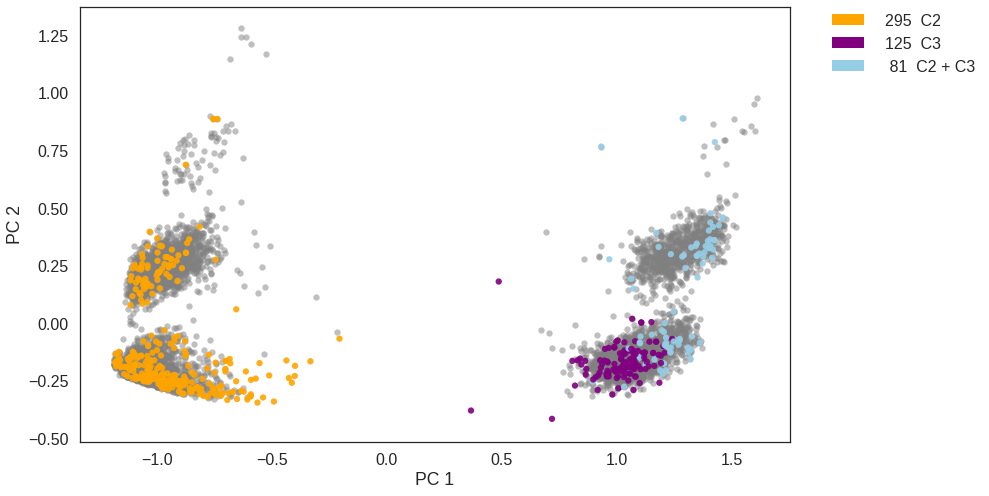

In [25]:
plot_shared_snps(f_pca, f_0_pca, mask, names, draw_all=True)

Кластеризация так и сяк.

0 outliers

Medians in clusters:
0 [ 0.16  0.15  0.97  0.84  0.78  0.93  0.57  0.14  0.64  0.72  0.97]
1 [ 0.01  0.03  0.    0.01  0.02  0.06  0.12  0.03  0.02  0.2   0.07]


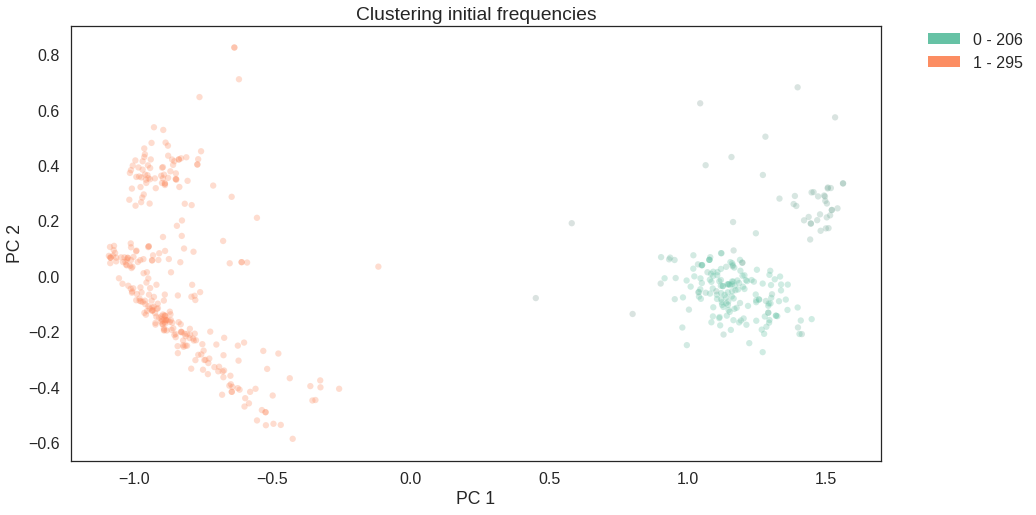

In [11]:
clusterization(f, pca=False)

0 outliers

Medians in clusters:
0 [ 0.16  0.15  0.97  0.84  0.78  0.93  0.57  0.14  0.64  0.72  0.97]
1 [ 0.01  0.03  0.    0.01  0.02  0.06  0.12  0.03  0.02  0.2   0.07]


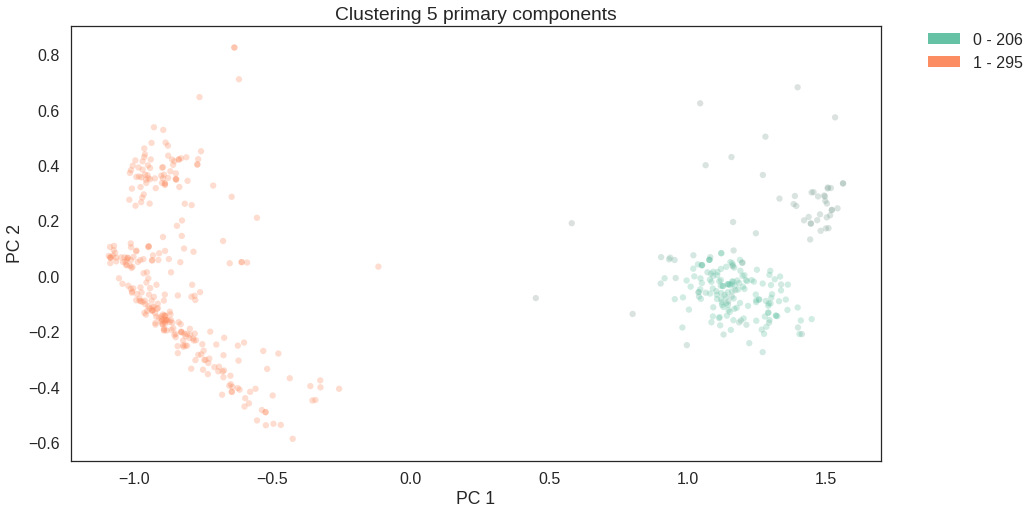

In [12]:
clusterization(f, pca=True, num_of_comp=5)